#PROYECTO FINAL MINE-4101: CIENCIA DE DATOS APLICADA - SEGUNDA ENTREGA

Oscar Fernando Bosigas Puerto – 202220008 - o.bosigas

Yeimy Andrea Cano M – 202213304 - y.cano

David Polania Mejia - 202213328 - d.polaniam


In [ ]:
#Importaciones necesarias

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#from pandas_profiling import ProfileReport
from datetime import datetime
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# **Entendimiento de los Datos**

Primero se procede a hacer el cargue de los datos que están en el repositorio git del proyecto.

In [ ]:
cosechas= pd.read_csv('https://raw.githubusercontent.com/OscarBosigas/Proyecto-Final-Ciencia-de-Datos-Aplicada/main/Evaluaciones_Agropecuarias_Municipales_EVA.csv', sep = ',')

El diccionario de datos provistos es:

| Nombre de la columna | Descripción| 
| --- | --- |
|COD DEPARTAMENTO|	Código del departamento, según lo establecido por el DANE|
|DEPARTAMENTO|	Departamento Colombiano|
|COD MUNICIPIO|	Código del municipio, según lo establecido por el DANE|
|MUNICIPIO|	Municipio Colombiano|
|GRUPO DE CULTIVO|	Categoría del cultivo|
|SUBGRUPO DE CULTIVO|	Tipo de cultivo según categoría|
|CULTIVO|	Nombre del cultivo|
|DESAGRAGACION REGIONAL Y/O SISTEMA PRODUCTIVO|	Nombre genérico del cultivo|
|AÑO|	Año de producción|
|PERIODO|	Periodo médico, siendo A los primeros 6 meses y B los últimos|
|ÁREA SEMBRADA (ha)|	Área sembrada en hectáreas|
|ÁREA COSECHADA (ha)|	Área cosechada en hectáreas|
|PRODUCCIÓN (t)|	Tiempo de producción|
|RENDIMIENTO (t/ha)|	Rendimiento de la cosecha|
|ESTADO FISICO PRODUCCION|	Estado del producto|
|NOMBRE CIENTIFICO|	Nombre científico del cultivo|
|CICLO DE CULTIVO|	Ciclo del cultivo en el país|


In [ ]:
cosechas.shape

(206068, 17)

# **Preparación de los Datos**

## Limpieza de datos

Primero se aplica la limpieza y procesamiento de datos que se definieron en la entrega dos (ver ProyectoFinalScripts.ipynb en carpeta entrega 2)

In [ ]:
cosechas.at[335, "MUNICIPIO"]="BAJO BAUDO"
#confirmar que ya no está el valor nulo de municipio
cosechas[cosechas['MUNICIPIO'].isnull()]

,CÓD. DEP.,DEPARTAMENTO,CÓD. MUN.,MUNICIPIO,GRUPO DE CULTIVO,SUBGRUPO DE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,AÑO,PERIODO,Área Sembrada (ha),Área Cosechada(ha),Producción (t),Rendimiento (t/ha),ESTADO FISICO PRODUCCION,NOMBRE CIENTIFICO,CICLO DE CULTIVO


Se define la función "preprocess" para ejecutar las acciones requeridas para el alistamiento de datos para posteriormente usarlo en el modelamiento:

In [ ]:
def preprocess(df):
  #Eliminar columnas "CÓD. DEP.", "'CÓD. MUN.", "SUBGRUPO DE CULTIVO?", "CULTIVO", "DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO", 'Área Cosechada(ha)', "Rendimiento (t/ha)", "NOMBRE CIENTIFICO": 
  df = df.drop(['CÓD. DEP.', 'CÓD. MUN.', 'SUBGRUPO DE CULTIVO', 'CULTIVO', 'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO', 'Área Cosechada(ha)', 'Rendimiento (t/ha)', 'NOMBRE CIENTIFICO'], axis=1)

  #Separar la columna de periodo
  df['PERIODO'] = df['PERIODO'].str.replace(r'\d{4}(?=[A-z])','')
  df['PERIODO'] = df['PERIODO'].str.replace(r'\d{4}','C')

  #Borrar los registros que tienen valor de 0 en la variable objetivo
  df = df.drop(df[df['Producción (t)']==0].index)

  df.reset_index(drop=True, inplace=True)
  return df

Una vista de nuestros datos depués de la limpieza es:

In [ ]:
data = preprocess(cosechas)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,DEPARTAMENTO,MUNICIPIO,GRUPO DE CULTIVO,AÑO,PERIODO,Área Sembrada (ha),Producción (t),ESTADO FISICO PRODUCCION,CICLO DE CULTIVO
0,BOYACA,BUSBANZA,HORTALIZAS,2006,B,2,1,FRUTO FRESCO,TRANSITORIO
1,CUNDINAMARCA,SOACHA,HORTALIZAS,2006,B,82,1440,FRUTO FRESCO,TRANSITORIO
2,CUNDINAMARCA,COTA,HORTALIZAS,2006,B,2,26,FRUTO FRESCO,TRANSITORIO
3,NORTE DE SANTANDER,LOS PATIOS,HORTALIZAS,2006,B,3,48,FRUTO FRESCO,TRANSITORIO
4,NORTE DE SANTANDER,PAMPLONA,HORTALIZAS,2006,B,1,5,FRUTO FRESCO,TRANSITORIO


In [ ]:
data2 = data.copy()
data2.head()

,DEPARTAMENTO,MUNICIPIO,GRUPO DE CULTIVO,AÑO,PERIODO,Área Sembrada (ha),Producción (t),ESTADO FISICO PRODUCCION,CICLO DE CULTIVO
0,BOYACA,BUSBANZA,HORTALIZAS,2006,B,2,1,FRUTO FRESCO,TRANSITORIO
1,CUNDINAMARCA,SOACHA,HORTALIZAS,2006,B,82,1440,FRUTO FRESCO,TRANSITORIO
2,CUNDINAMARCA,COTA,HORTALIZAS,2006,B,2,26,FRUTO FRESCO,TRANSITORIO
3,NORTE DE SANTANDER,LOS PATIOS,HORTALIZAS,2006,B,3,48,FRUTO FRESCO,TRANSITORIO
4,NORTE DE SANTANDER,PAMPLONA,HORTALIZAS,2006,B,1,5,FRUTO FRESCO,TRANSITORIO


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202261 entries, 0 to 202260
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   DEPARTAMENTO              202261 non-null  object
 1   MUNICIPIO                 202261 non-null  object
 2   GRUPO DE CULTIVO          202261 non-null  object
 3   AÑO                       202261 non-null  int64 
 4   PERIODO                   202261 non-null  object
 5   Área Sembrada (ha)        202261 non-null  int64 
 6   Producción (t)            202261 non-null  int64 
 7   ESTADO FISICO PRODUCCION  202261 non-null  object
 8   CICLO DE CULTIVO          202261 non-null  object
dtypes: int64(3), object(6)
memory usage: 13.9+ MB


Por el hallazgo de tener valores muy altos en la varaible a predecir, y de acuerdo con las sugerencias de la entrega dos se plantea hacer una transformación logarítmica.


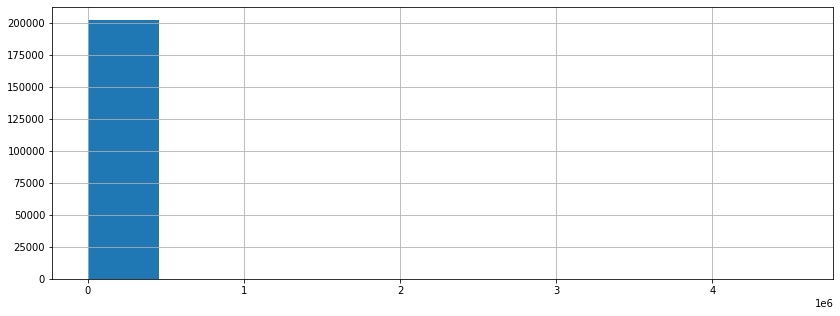

In [ ]:
data['Producción (t)'].hist(figsize=(14, 5));

In [ ]:
data2 = data.copy()
data2.head()

,DEPARTAMENTO,MUNICIPIO,GRUPO DE CULTIVO,AÑO,PERIODO,Área Sembrada (ha),Producción (t),ESTADO FISICO PRODUCCION,CICLO DE CULTIVO
0,BOYACA,BUSBANZA,HORTALIZAS,2006,B,2,1,FRUTO FRESCO,TRANSITORIO
1,CUNDINAMARCA,SOACHA,HORTALIZAS,2006,B,82,1440,FRUTO FRESCO,TRANSITORIO
2,CUNDINAMARCA,COTA,HORTALIZAS,2006,B,2,26,FRUTO FRESCO,TRANSITORIO
3,NORTE DE SANTANDER,LOS PATIOS,HORTALIZAS,2006,B,3,48,FRUTO FRESCO,TRANSITORIO
4,NORTE DE SANTANDER,PAMPLONA,HORTALIZAS,2006,B,1,5,FRUTO FRESCO,TRANSITORIO


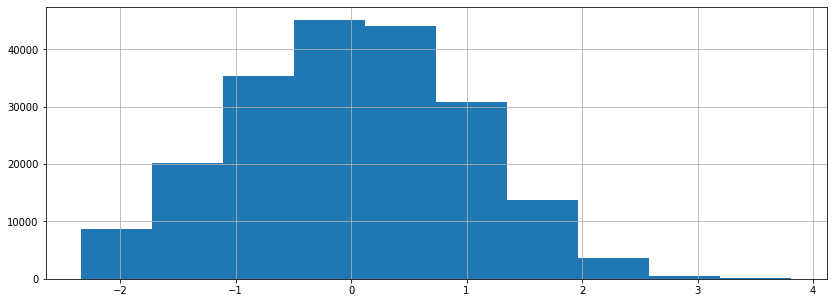

In [ ]:
#aplicando la transformación logaritmica a la varible de predicción:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

data2['Producción (t)'] = pd.DataFrame(pt.fit_transform(data[["Producción (t)"]]), columns=['Producción (t)'])
data2['Producción (t)'].hist(figsize=(14, 5));

In [ ]:
data2.head()

,DEPARTAMENTO,MUNICIPIO,GRUPO DE CULTIVO,AÑO,PERIODO,Área Sembrada (ha),Producción (t),ESTADO FISICO PRODUCCION,CICLO DE CULTIVO
0,BOYACA,BUSBANZA,HORTALIZAS,2006,B,2,-2.337909,FRUTO FRESCO,TRANSITORIO
1,CUNDINAMARCA,SOACHA,HORTALIZAS,2006,B,82,1.038674,FRUTO FRESCO,TRANSITORIO
2,CUNDINAMARCA,COTA,HORTALIZAS,2006,B,2,-0.854928,FRUTO FRESCO,TRANSITORIO
3,NORTE DE SANTANDER,LOS PATIOS,HORTALIZAS,2006,B,3,-0.544161,FRUTO FRESCO,TRANSITORIO
4,NORTE DE SANTANDER,PAMPLONA,HORTALIZAS,2006,B,1,-1.685984,FRUTO FRESCO,TRANSITORIO


Ahora se renombran las columnas para que pueda ser compatible con el API de la aplicación. 

In [ ]:
data2 = data2.rename(columns={'AÑO':'year', 'Área Sembrada (ha)':'area', 'DEPARTAMENTO': 'departamento',	'MUNICIPIO': 'municipio',	'GRUPO DE CULTIVO':'grupo_cultivo',	
                              'PERIODO':'period',	'ESTADO FISICO PRODUCCION':'estado_produccion',	'CICLO DE CULTIVO':'ciclo_cultivo'})


# **Modelamiento**

Con el procesamiento descrito anteriormente, seguimos a realizar la divisón de los datos entre entrenamiento y evaluación en una relación de 20% y 80% respectivamente

In [ ]:
Y = data2['Producción (t)']

X_train, X_test, Y_train, Y_test = train_test_split(data2.drop('Producción (t)',axis=1), Y, test_size = 0.2, random_state = 100)

In [ ]:
X_train.head()

,departamento,municipio,grupo_cultivo,year,period,area,estado_produccion,ciclo_cultivo
80441,NARIÑO,YACUANQUER,LEGUMINOSAS,2012,B,750,GRANO SECO,TRANSITORIO
79265,SANTANDER,SAN GIL,LEGUMINOSAS,2017,B,186,GRANO SECO,TRANSITORIO
67833,NARIÑO,ARBOLEDA,FIBRAS,2015,C,341,FIBRA SECA,PERMANENTE
192315,ANTIOQUIA,CAICEDO,TUBERCULOS Y PLATANOS,2009,C,75,TUBERCULO FRESCO,ANUAL
27427,NARIÑO,MAGUI PAYAN,FRUTALES,2009,C,12,FRUTO FRESCO,PERMANENTE


In [ ]:
Y_train

80441     0.709450
79265     0.069788
67833     0.700823
192315    0.756037
27427    -0.661983
            ...   
194442   -1.042985
65615    -0.265847
77655    -0.370227
56088    -0.289867
38408     0.609915
Name: Producción (t), Length: 161808, dtype: float64

## **PipeLine**

Se genera un pipeline que realice los procesos de OneHotEncoder de las variables categóricas, seguido de la normalización de los datos y finalmente el algoritmo de RandomForest para que entrene el modelo. Se toma randomForest dado que fue el mejor modelo en la entrega dos y se espera ver mejoras después de aplicar la transformación de logaritmo en la variable objetivo.

In [ ]:
X_train.columns

Index(['departamento', 'municipio', 'grupo_cultivo', 'year', 'period', 'area',
       'estado_produccion', 'ciclo_cultivo'],
      dtype='object')

In [ ]:
#pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('categorical', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), ['departamento', 'municipio', 'grupo_cultivo', 'period', 'estado_produccion', 'ciclo_cultivo'])
    ], remainder = 'passthrough')),
    ('normalizer', MinMaxScaler()),
    ('classifier',  RandomForestRegressor())
]) 

In [ ]:
param_grid2 = [
    {
        'classifier': [RandomForestRegressor()],
        'classifier__n_estimators':[100,200,500],
        'classifier__max_depth': [None,1,3],
    }
]

In [ ]:
grid2 = GridSearchCV(estimator = pipeline, param_grid = param_grid2, scoring = ['precision', 'recall', 'f1'], n_jobs = 1, refit = 'f1', cv = 5, return_train_score = True, verbose = 2)

In [ ]:
grid2.fit(X_train, Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=100; total time= 9.7min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=100; total time= 9.3min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=100; total time= 9.4min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=200; total time=19.0min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=200; total time=19.3min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=200; total time=19.0min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_division=zero_division,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 1544, in precision_recall_fscore_suppo

[CV] END classifier=RandomForestRegressor(), classifier__max_depth=None, classifier__n_estimators=500; total time=48.3min


Se obtienen las métrica para evaluar el modelo con lso datos de entrenamiento y prueba. como se comentó en la entrega dos, por ser un problema de regresión se consideran las métricas del error absoluto medio y el R2-score.

In [ ]:
#predicciones con los datos de entrenamiento , 
pred_train = grid2.best_estimator_.predict(X_train)
pred_test = grid2.best_estimator_.predict(X_test)

#Métrica de valor absoluto del error:
print("Error para datos entrenamiento:", mean_absolute_error(Y_train, pred_train))
print("Error para datos :", mean_absolute_error(Y_test, pred_test))

#R2 Score:
print("R2-score para datos entrenamiento: %.5f" % r2_score(Y_train, pred_train))
print("R2-score para datos entrenamiento: %.5f" % r2_score(Y_test, pred_test))

Error para datos entrenamiento: 0.0702090663465669
Error para datos : 0.18074600275886554
R2-score para datos entrenamiento: 0.98751
R2-score para datos entrenamiento: 0.92368


si bien disminuyó un poco el R2-score del modelo respecto al de la entrega 2, con la transformación logaritmica si vemos que disminuyó un poco el error absoluto medio con los datos de prueba. 

Se hace conexión con colab para almacenar el modelo y el transformador pt usado, esto para tenerlos en la aplicación que predice y que requiere hacer el inverso de la transformación de la variable a predecir para entregarlo en los valores normales.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from joblib import dump
dump(grid2.best_estimator_, '/content/drive/MyDrive/BestModelRF/RF.joblib')
dump(grid2.best_params_, '/content/drive/MyDrive/BestModelRF/best_tfidf.pkl', compress = 1)
dump(pt, '/content/drive/MyDrive/BestModelRF/pt.joblib') 

['/content/drive/MyDrive/pt.joblib']

##Predicciones:

In [ ]:
df = pd.concat([X_test, pd.DataFrame(Y_test)], axis=1)

In [ ]:
pred_test

array([-0.58683285,  0.00618539,  1.02346403, ..., -1.3457146 ,
       -0.38398555, -0.11317343])

In [ ]:
df2 = pd.concat([df.reset_index(drop=True), pd.DataFrame(pred_test, columns = ['Y_predict'])], axis=1)
df2.head()

,departamento,municipio,grupo_cultivo,year,period,area,estado_produccion,ciclo_cultivo,Producción (t),Y_predict
0,CAQUETA,SAN JOSE DEL FRAGUA,FRUTALES,2013,C,7,FRUTO FRESCO,PERMANENTE,-0.576625,-0.586833
1,ANTIOQUIA,CALDAS,TUBERCULOS Y PLATANOS,2012,A,8,TUBERCULO FRESCO,TRANSITORIO,0.046518,0.006185
2,VALLE DEL CAUCA,LA CUMBRE,TUBERCULOS Y PLATANOS,2008,C,108,FRUTO FRESCO,PERMANENTE,0.542553,1.023464
3,BOYACA,DUITAMA,HORTALIZAS,2017,A,300,HORTALIZA FRESCA,TRANSITORIO,1.747958,1.709629
4,CAUCA,CALOTO,LEGUMINOSAS,2006,B,3,LEGUMINOSA FRESCA,TRANSITORIO,-1.396000,-1.691238


In [ ]:
df2["Y"] = pd.DataFrame(pt.inverse_transform(df2[["Producción (t)"]]), columns=['Producción (t)'])

Se hace una vista de los datos de test con las columnas:

*   Producción (t): Valor a predecir transformado logaritmicamente
*   Y_predict: Valor que predice el modelo (valor logaritmico)
*   Y: Vaolo original de la varaible objetivo
*   Y2: Valor predicho por el modelo luego de hacer el inverso de la transformación logaritmica.



In [ ]:
df2["Y2"] = pd.DataFrame(pt.inverse_transform(df2[["Y_predict"]]), columns=['Y_predict'])
df2.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Y_predict
Feature names seen at fit time, yet now missing:
- Producción (t)

  warnings.warn(message, FutureWarning)


,departamento,municipio,grupo_cultivo,year,period,area,estado_produccion,ciclo_cultivo,Producción (t),Y_predict,Y,Y2
0,CAQUETA,SAN JOSE DEL FRAGUA,FRUTALES,2013,C,7,FRUTO FRESCO,PERMANENTE,-0.576625,-0.586833,45.0,44.097193
1,ANTIOQUIA,CALDAS,TUBERCULOS Y PLATANOS,2012,A,8,TUBERCULO FRESCO,TRANSITORIO,0.046518,0.006185,160.0,147.065943
2,VALLE DEL CAUCA,LA CUMBRE,TUBERCULOS Y PLATANOS,2008,C,108,FRUTO FRESCO,PERMANENTE,0.542553,1.023464,465.0,1389.506006
3,BOYACA,DUITAMA,HORTALIZAS,2017,A,300,HORTALIZA FRESCA,TRANSITORIO,1.747958,1.709629,8260.0,7483.066646
4,CAUCA,CALOTO,LEGUMINOSAS,2006,B,3,LEGUMINOSA FRESCA,TRANSITORIO,-1.396000,-1.691238,9.0,4.945505
5,HUILA,TIMANA,CEREALES,2018,A,120,GRANO SECO,TRANSITORIO,-0.003921,0.132176,144.0,191.588295
6,ANTIOQUIA,SANTUARIO,LEGUMINOSAS,2017,A,420,GRANO SECO,TRANSITORIO,0.648040,0.645008,588.0,584.023284
7,VALLE DEL CAUCA,BUGA,CEREALES,2006,B,260,GRANO SECO,TRANSITORIO,0.995014,0.956622,1300.0,1188.736425
8,META,CUMARAL,OTROS PERMANENTES,2016,C,26,CAFE VERDE EQUIVALENTE,PERMANENTE,-0.874952,-0.880927,25.0,24.709247
9,NARIÑO,ALBAN,CEREALES,2017,B,20,GRANO SECO,TRANSITORIO,-0.874952,-0.693282,25.0,35.722959


In [ ]:
#Se guarda copia de la tabla de test con sus predicciones.
df2.to_csv("/content/drive/MyDrive/BestModelRF/prediccionesRF.csv") 